# Simulate Prosumers in a NRG-X-Change Connected Market 

## Description:
Prosumers are collected as a model with the consumption, generation, net energy and pricing data avaialble. The prosumer data has been built based on Tier1 installations for the purposes of modeling a typical prosumer. The limits on the capacity for Teir1 are also considered. In this simulation parameters for the gross power ratings, AC/DC conversion, will be considered as well as the generation limits. 

**What is NRG-X-Change?**
"In  this  paper  we  propose  NRG-X-Change  —  anovel mechanism for trading of locally produced re-newable energy that does not rely on an energy mar-ket or matching of orders ahead of time. In our modellocally produced energy is continuously fed into thegrid and payment is received based on actual usage,rather than predicted, as consumption is measured bythe DSO and billed in near real-time." (Mihail Mihaylov)

## Steps:
### 1. Data Gathering 

### 2. Build the NRG-X-Change Simulation

### 3. Analyze Results

### 4. Summary and Further Analysis


In [1]:
#import data from sources
import pandas as pd
from functools import reduce
import requests 
import os
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import random
from tabulate import tabulate
import math
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

# Step 1 : Data Gathering
## 1.1 Collecting Data From Local Dataset
The prosumer data has been built into a Comma-Sperated file that can be parsed with the following format:

| time                |   demand |   generation |   consumption |   net_energy |   price | id      |
|---------------------|----------|--------------|---------------|--------------|---------|---------|
| 2020-11-01 00:00:00 |  621.143 |     1115.12  |        0      |    -493.98   |   12    | 1
| 2020-10-01 00:00:00 | 1110.06  |     1178.87  |        0      |     -68.8135 |   11.49 | 1
| 2020-09-01 00:00:00 | 1226.16  |     1026.59  |      199.568  |       0      |   11.97 | 1
| 2020-08-01 00:00:00 | 1002.64  |      972.796 |       29.8479 |       0      |   11.61 | 1
...(continued)

Parsing the dataset by the 'id' col. allows us to collect individual prosumer data. The next step is to 
put the prosumer data into an object class that contains some of the functionality we will perform on the 
data.

In [2]:
#Import the data to local csv
all_prosumers_data = pd.read_csv('data/prosumer_N3_model_20210129_1416.csv') 
all_prosumers_data["time"] = pd.to_datetime(all_prosumers_data['time'], format='%Y-%m-%d %H:%M')
all_prosumers_data.sort_values(by='time')
prosumer_data_by_id = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('id', as_index=False)]
N=len(prosumer_data_by_id)
prosumers_at_t = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('time', as_index=False)]

#print(prosumer_data[0]) #show the first prosumer in the dataset
print(all_prosumers_data)

         time       demand   generation  consumption  net_energy  price  id
0  2020-11-01   713.636892  1001.611236     0.000000 -287.974344  12.00   1
1  2020-10-01  1033.715254  1124.283176     0.000000  -90.567922  11.49   1
2  2020-09-01  1169.504690  1200.000000     0.000000  -30.495310  11.97   1
3  2020-08-01   745.056436  1118.585765     0.000000 -373.529328  11.61   1
4  2020-07-01  1088.967130  1075.337671    13.629459    0.000000  11.71   1
5  2020-06-01  1202.880127   979.940026   222.940101    0.000000  11.53   1
6  2020-05-01   839.217153   945.914118     0.000000 -106.696964   9.84   1
7  2020-04-01   726.229347  1042.016842     0.000000 -315.787495  11.71   1
8  2020-03-01  1136.909963   767.108299   369.801664    0.000000  11.64   1
9  2020-02-01   405.862473   787.888820     0.000000 -382.026347  11.76   1
10 2020-01-01   666.182080   788.227717     0.000000 -122.045637  11.73   1
11 2019-12-01   785.346708   491.636087   293.710621    0.000000  11.62   1
12 2019-11-0

# 2. Build the NRG-X-Change Simulation

## 2.1 Define the Energy Pay-Out Function, g(.)

$$ g(x,t_p,t_c) = \frac{​​x^n* q_{t_p=t_c}​​}{e^{\frac{(t_p - t_c)^2}{a}}} $$

Where $x$, is the net energy of the prosumer. $q$, is the maximum price allowed. $t_p$ ,is the total produced energy of all prosumers. $t_c$ is the total consumption of all the prosumers. $a$ , is a scaling constant to adjust the pay out.  The NRG exchange cost mechanisim includes a wheighted distribution to adjust for the need of energy consumption when the demand is the highest and drops the pricing when demand is the lowest. We will use the largest value of our pricing history to determine the $q$ parameter. The maximum payout for the price of electricity over the course of the year can vary so it is taken as a historical maximum and assumed to continue in the future based on regulatory rate cases.




In [3]:
def g(price,p,tp,tc,a,n):
    x = p
    a=1
    n=1
    q = (0.01*price)
    try:
        pay = abs((pow(x,n)*q)/math.exp(pow((tp-tc),2)/a))
    except OverflowError:
        pay = float('inf')
    return pay

## 2.2 Define the Energy Cost Function, h(.)

$$ h(y,t_p,t_c) = \frac{y*r_{t_c>>t_p}​*t_c​}{t_c+t_p} $$

Where $y$ is the withdrawn energy, and $r_{t_c>>t_p}​$ is the maximum cost of energy delivered by the utility when the energy supply by prosumers is low. Again, $t_p$ is the total production and $t_c$ is the total consumption of the prosumers in the network. The minimum payment by the utility in the historical payment prices would indicate the minimum amount willing to charge customers for energy in order to cover the cost of delivering the energy. We will use the minimum price in our list for $r$.

In [4]:
def h(price,c,tp,tc):
    y = c
    r = (0.01*price)
    try:
        cost = (y*r*tc)/(tc+tp)
    except OverflowError:
        cost = float('inf')
    return cost



## 2.3 Generate Market Results

In [5]:
#split prosumers by time slice
#prosumer_data_by_id[0]
prosumers_at_t[0]


,time,demand,generation,consumption,net_energy,price,id
13,2019-10-01,785.747309,567.176089,218.571220,0.000000,11.66,1
27,2019-10-01,706.638381,897.462539,0.000000,-190.824158,11.66,2
41,2019-10-01,996.729985,392.570712,604.159273,0.000000,11.66,3


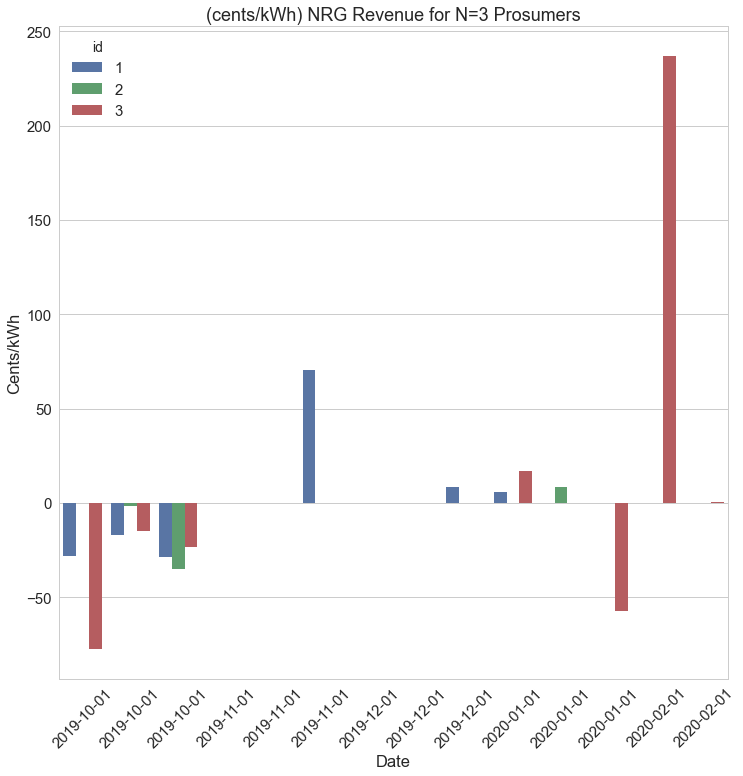

In [6]:

#historical pricing 
max_price = all_prosumers_data['price'].max()
min_price = all_prosumers_data['price'].min()

#calculate the payment at time t, for all prosumers
payments=[]
t_periods = len(prosumers_at_t)
for i in range(t_periods):
    tc = prosumers_at_t[i]['consumption'].sum()
    tp = prosumers_at_t[i]['net_energy'].sum()
    k = 0
    for index, prosumer in prosumers_at_t[i].iterrows():
        pay = 0
        if prosumer['net_energy'] > 0: 
            pay = g(price=max_price,p=prosumer['net_energy'],tc=tc,tp=tp)
        else:
            # payment is negative to show debt by consumer
            pay = -(h(price=min_price,c=prosumer['consumption'],tc=tc,tp=tp))
        time = prosumers_at_t[i]['time'].values[k]
        id = prosumers_at_t[i]['id'].values[k]
        payments.append([time,id,pay])
        k=k+1

#print(payments_df)
payments_df = pd.DataFrame(payments,columns=['time','id','nrg_pay'])
payments_df['time'] = pd.to_datetime(payments_df['time'], format='%Y-%m-%d')
        
# Use white grid plot background from seaborn        
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))

# Set title and labels for axes
ax = sns.barplot(x="time", y="nrg_pay", hue="id", data=payments_df)
ax.set(xlabel="Date",
       ylabel="Cents/kWh",
       title=f"(cents/kWh) NRG Revenue for N={N} Prosumers")
ax.xaxis_date()

# Ensure a major tick for each week using (interval=1) 
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xticklabels([pd.to_datetime(tm).strftime('%Y-%m-%d') for tm in payments_df['time']])
plt.xticks(rotation=45)
plt.show()


# Step 3: Analysis of Performance
## 2.1 Analyze the Performance by Prosumer
Durng an NRG market teh prosumers where achieving the greatest returns when genreation was the lowest.  



## 2.3 Analysis of the Market Performance for 100 Prosumers
To understand the scalability of the market, we will simulate N=100 prosumers. The charts will show the same volatility curves and calcualte the revenue, from the profit and expenses during the demand and generation curves.

In [7]:
#Import the data to local csv
all_prosumers_data = pd.read_csv('data/prosumer_N100_model_20210129_1414.csv') 
all_prosumers_data["time"] = pd.to_datetime(all_prosumers_data['time'], format='%Y-%m-%d %H:%M')
all_prosumers_data.sort_values(by='time')
prosumer_data_by_id = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('id', as_index=False)]
N=len(prosumer_data_by_id)
prosumers_at_t = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('time', as_index=False)]

#print(prosumer_data[0]) #show the first prosumer in the dataset
print(all_prosumers_data)

#historical pricing 
max_price = all_prosumers_data['price'].max()
min_price = all_prosumers_data['price'].min()

#calculate the payment at time t, for all prosumers
payments=[]
t_periods = len(prosumers_at_t)
for i in range(t_periods):
    tc = prosumers_at_t[i]['consumption'].sum()
    tp = prosumers_at_t[i]['net_energy'].sum()
    k = 0
    for index, prosumer in prosumers_at_t[i].iterrows():
        pay = 0
        if prosumer['net_energy'] > 0: 
            pay = g(price=max_price,p=prosumer['net_energy'],tc=tc,tp=tp)
        else:
            # payment is negative to show debt by consumer
            pay = -(h(price=min_price,c=prosumer['consumption'],tc=tc,tp=tp))
        time = prosumers_at_t[i]['time'].values[k]
        id = prosumers_at_t[i]['id'].values[k]
        payments.append([time,id,pay])
        k=k+1

#print(payments_df)
payments_df = pd.DataFrame(payments,columns=['time','id','nrg_pay'])
payments_df['time'] = pd.to_datetime(payments_df['time'], format='%Y-%m-%d')
print(payments_df)



           time       demand   generation  consumption  net_energy  price   id
0    2020-11-01   928.558449  1061.810263     0.000000 -133.251814  12.00    1
1    2020-10-01   952.496370   945.671067     6.825303    0.000000  11.49    1
2    2020-09-01   953.234234  1200.000000     0.000000 -246.765766  11.97    1
3    2020-08-01  1135.378044   901.152036   234.226009    0.000000  11.61    1
4    2020-07-01   648.729055  1074.617534     0.000000 -425.888479  11.71    1
5    2020-06-01  1253.202416  1189.318132    63.884284    0.000000  11.53    1
6    2020-05-01   775.415108  1139.274230     0.000000 -363.859121   9.84    1
7    2020-04-01   717.336216   868.937997     0.000000 -151.601781  11.71    1
8    2020-03-01   690.381161  1200.000000     0.000000 -509.618839  11.64    1
9    2020-02-01   638.943695   787.545678     0.000000 -148.601983  11.76    1
10   2020-01-01   696.291964   652.057768    44.234197    0.000000  11.73    1
11   2019-12-01   674.696334   640.294779    34.4015

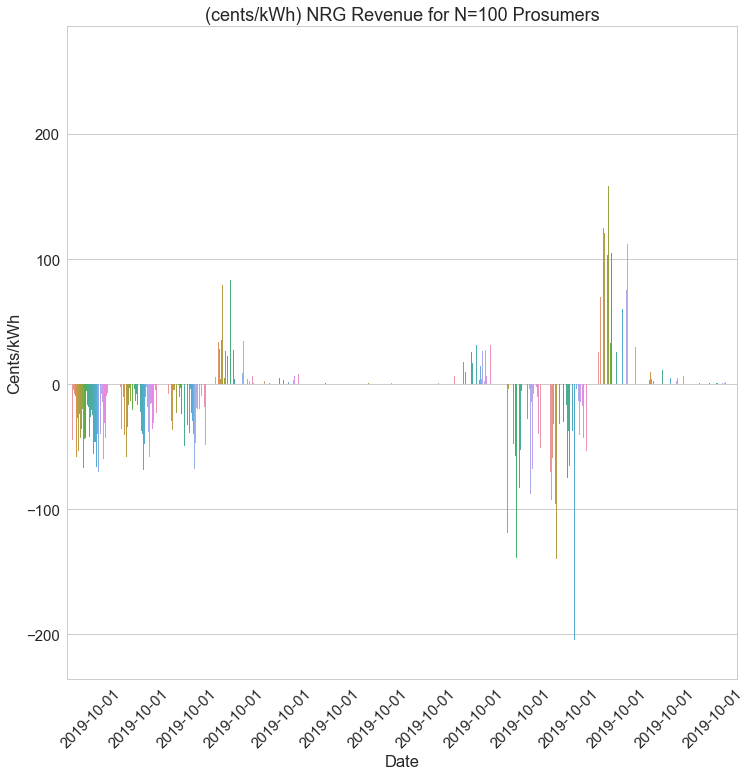

In [8]:

# Use white grid plot background from seaborn        
sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))

# Set title and labels for axes
ax = sns.barplot(x="time", y="nrg_pay", hue="id", data=payments_df)
ax.set(xlabel="Date",
       ylabel="Cents/kWh",
       title=f"(cents/kWh) NRG Revenue for N={N} Prosumers")
ax.xaxis_date()


# Ensure a major tick for each week using (interval=1) 
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xticklabels([pd.to_datetime(tm).strftime('%Y-%m-%d') for tm in payments_df['time']])
plt.xticks(rotation=45)
plt.legend('')
plt.show()


# Step 4: Summary and Further Studies


TBD
